In [1]:
# ！pip install functorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import pandas as pd
import scipy
from scipy import stats
import numpy as np
from os import path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
MA_DAYS = 25
trading_days_in_year = 252

# Import raw data from yahoo finance

In [4]:
from google.colab import drive
drive.mount('/content/drive')
data_files_path_prefix = "/content/drive/MyDrive"
data_files_path = "ML-Portfolio-Data"
data_files_path = path.join(data_files_path_prefix, data_files_path)

high_risk_file = 'SPY.csv'
low_risk_file = 'O9P.SI.csv'
high_risk = pd.read_csv(path.join(data_files_path, high_risk_file))
low_risk = pd.read_csv(path.join(data_files_path, low_risk_file))

Mounted at /content/drive


In [5]:
# Read files from the same directory
#high_risk = pd.read_csv('SPY.csv')
#low_risk = pd.read_csv('O9P.SI.csv')

In [6]:
high_risk = high_risk[:1008]
low_risk = low_risk[:1008]
print(high_risk.shape)
print(low_risk.shape)

(1008, 7)
(1008, 7)


In [7]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-28,245.169998,245.199997,244.089996,244.570007,224.240860,40565600
1,2017-08-29,243.059998,245.149994,242.929993,244.850006,224.497574,51135700
2,2017-08-30,244.830002,246.320007,244.619995,246.009995,225.561142,62030800
3,2017-08-31,246.720001,247.770004,246.050003,247.490005,226.918106,103803900
4,2017-09-01,247.919998,248.330002,247.669998,247.839996,227.239059,62007000


In [8]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-28,10.90,10.90,10.88,10.88,10.88,7400
1,2017-08-29,10.89,10.90,10.89,10.90,10.90,1400
2,2017-08-30,10.94,10.94,10.94,10.94,10.94,5300
3,2017-08-31,10.92,10.96,10.92,10.93,10.93,30700
4,2017-09-04,10.89,10.89,10.80,10.83,10.83,59800


# ML Portfolio

## Enrich data

### Calculate daily returns

In [9]:
def add_daily_return(market_data):
    market_data["Daily Return"]  = market_data['Close'] - market_data['Open']

add_daily_return(high_risk)
add_daily_return(low_risk)

### Calculate moving average (MA) of daily returns

In [10]:
def add_moving_average(market_data, ma_days):
    temp_vars = []

    # df = market_data
    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data[temp_var] = market_data["Daily Return"].shift(i)
        temp_vars.append(temp_var)

    market_data["MA"] = market_data[temp_vars].mean(axis=1)

    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data.drop(temp_var, axis = 1, inplace = True)

add_moving_average(high_risk, MA_DAYS)
add_moving_average(low_risk, MA_DAYS)


In [11]:
high_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
1003,2021-08-23,445.160004,448.230011,443.440002,447.260010,440.990021,54973000,2.100006,0.880400
1004,2021-08-24,447.970001,448.540009,447.420013,447.970001,441.690033,38744700,0.000000,0.665200
1005,2021-08-25,448.170013,449.459991,447.769989,448.910004,442.616913,40529700,0.739991,0.606400
1006,2021-08-26,448.609985,448.859985,446.160004,446.260010,440.004089,57829600,-2.349975,0.483601
1007,2021-08-27,447.119995,450.649994,447.059998,450.250000,443.938110,77235100,3.130005,0.512001


In [12]:
low_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
1003,2021-08-24,9.83,9.86,9.81,9.84,9.84,19960,0.01,-0.0316
1004,2021-08-25,9.90,9.90,9.85,9.86,9.86,102205,-0.04,-0.0320
1005,2021-08-26,9.89,9.89,9.86,9.86,9.86,66520,-0.03,-0.0296
1006,2021-08-27,9.90,9.90,9.86,9.88,9.88,68015,-0.02,-0.0308
1007,2021-08-30,9.79,9.79,9.77,9.78,9.78,1017465,-0.01,-0.0312


### Calculate ROE

In [13]:
def add_roe(market_data):    
    market_data["Prev Close"] = market_data["Close"].shift(1)
    market_data["ROE"] = (market_data["Close"] - market_data["Prev Close"]) / market_data['Prev Close']

add_roe(high_risk)
add_roe(low_risk)

In [14]:
def add_roe_binary(market_data, tau=-0.005):    
    market_data["ROE Binary"] = np.where(market_data["ROE"].values < tau, 0, 1)

add_roe_binary(high_risk)
add_roe_binary(low_risk)

In [15]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
0,2017-08-28,245.169998,245.199997,244.089996,244.570007,224.240860,40565600,-0.599991,-0.599991,NaN,NaN,1
1,2017-08-29,243.059998,245.149994,242.929993,244.850006,224.497574,51135700,1.790008,0.595009,244.570007,0.001145,1
2,2017-08-30,244.830002,246.320007,244.619995,246.009995,225.561142,62030800,1.179993,0.790003,244.850006,0.004738,1
3,2017-08-31,246.720001,247.770004,246.050003,247.490005,226.918106,103803900,0.770004,0.785004,246.009995,0.006016,1
4,2017-09-01,247.919998,248.330002,247.669998,247.839996,227.239059,62007000,-0.080002,0.612002,247.490005,0.001414,1


In [16]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
0,2017-08-28,10.90,10.90,10.88,10.88,10.88,7400,-0.02,-0.020000,NaN,NaN,1
1,2017-08-29,10.89,10.90,10.89,10.90,10.90,1400,0.01,-0.005000,10.88,0.001838,1
2,2017-08-30,10.94,10.94,10.94,10.94,10.94,5300,0.00,-0.003333,10.90,0.003670,1
3,2017-08-31,10.92,10.96,10.92,10.93,10.93,30700,0.01,0.000000,10.94,-0.000914,1
4,2017-09-04,10.89,10.89,10.80,10.83,10.83,59800,-0.06,-0.012000,10.93,-0.009149,0


## Build feature space

In [17]:
def remove_for_ma(market_data, ma_days):
  return market_data[ma_days:]

high_risk = remove_for_ma(high_risk, MA_DAYS)
low_risk = remove_for_ma(low_risk, MA_DAYS)

In [18]:
print(high_risk.shape)

(983, 12)


In [19]:
def standardize_columns(market_data, columns):
  for column in columns:
    market_data[column] = market_data[column]/market_data[column].std()

standardize_columns(high_risk, ['Volume', 'Daily Return', 'MA'])
standardize_columns(low_risk, ['Volume', 'Daily Return', 'MA'])

<ipython-input-19-d0986728a5f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data[column] = market_data[column]/market_data[column].std()


In [20]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
25,2017-10-03,252.320007,252.889999,252.229996,252.860001,232.992355,1.367891,0.208144,0.708710,252.320007,0.002140,1
26,2017-10-04,252.690002,253.440002,252.559998,253.160004,233.268799,1.145610,0.181166,0.583476,252.860001,0.001186,1
27,2017-10-05,253.539993,254.679993,253.199997,254.660004,234.650909,1.300584,0.431716,0.577785,253.160004,0.005925,1
28,2017-10-06,254.149994,254.699997,253.850006,254.369995,234.383713,1.651169,0.084801,0.525604,254.660004,-0.001139,1
29,2017-10-09,254.630005,254.699997,253.649994,253.949997,233.996689,0.733043,-0.262114,0.468679,254.369995,-0.001651,1


In [21]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
25,2017-10-03,10.86,10.87,10.86,10.86,10.86,0.659605,0.000000,-0.383962,10.85,0.000922,1
26,2017-10-04,10.86,10.86,10.86,10.86,10.86,0.000000,0.000000,-0.393561,10.86,0.000000,1
27,2017-10-05,10.89,10.89,10.88,10.88,10.88,0.172782,-0.045821,-0.403161,10.86,0.001842,1
28,2017-10-06,10.89,10.89,10.87,10.88,10.88,0.371247,-0.045821,-0.422359,10.88,0.000000,1
29,2017-10-09,10.88,10.88,10.85,10.88,10.88,0.254503,0.000000,-0.364764,10.88,0.000000,1


In [22]:
def to_X_train_features(low_risk, high_risk):
  high_risk_train = high_risk[:1000]
  low_risk_train = low_risk[:1000]
  return np.vstack((high_risk_train['Daily Return'], high_risk_train['MA'], high_risk_train['Volume'], low_risk_train['Daily Return'], low_risk_train['MA'], low_risk_train['Volume']))

X = to_X_train_features(low_risk, high_risk).T
print(X.shape, X)

(983, 6) [[ 0.20814449  0.7087102   1.36789127  0.         -0.38396238  0.65960516]
 [ 0.18116558  0.58347574  1.14561011  0.         -0.39356144  0.        ]
 [ 0.43171613  0.57778499  1.30058409 -0.04582138 -0.4031605   0.17278153]
 ...
 [ 0.28523475  1.43829291  0.82981674 -0.13746413 -0.71033041  0.77658292]
 [-0.90581443  1.1470315   1.18401988 -0.09164275 -0.73912759  0.79403619]
 [ 1.20648249  1.2143914   1.58133367 -0.04582138 -0.74872665 11.87832143]]


In [23]:
def to_Y_train_features(low_risk, high_risk):
  high_risk_train = high_risk[0:1000]
  return high_risk_train['ROE Binary'].values

Y = to_Y_train_features(low_risk, high_risk)
print(Y.shape, Y)

(983,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0
 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0
 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0
 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1

## Build graph

In [24]:
X_tensor = torch.from_numpy(X)
print(type(X), X.shape, X_tensor.size())
Y_tensor = torch.from_numpy(Y).double()
print(type(Y), Y.shape, Y_tensor.size())

<class 'numpy.ndarray'> (983, 6) torch.Size([983, 6])
<class 'numpy.ndarray'> (983,) torch.Size([983])


In [25]:
a = torch.randn((6), requires_grad=True, dtype=torch.double)
b = torch.randn((6), requires_grad=True, dtype=torch.double)
print(a, a.size(), b, b.size())

tensor([-0.5998, -0.9504,  0.4737, -2.3196, -0.1056,  0.7316],
       dtype=torch.float64, requires_grad=True) torch.Size([6]) tensor([-0.9875,  0.8045, -1.1701,  0.9258,  0.5492, -1.1747],
       dtype=torch.float64, requires_grad=True) torch.Size([6])


In [26]:
lr = 1e-1
n_epochs = 500
torch.manual_seed(42)
lambda1 = 1e-3 #0.5
lambda2 = 1e-3 #0.5

loss_fn = nn.BCELoss()
optimizer = optim.SGD([a, b], lr=lr)

In [27]:
for epoch in range(n_epochs):
  
    yhat = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))

    loss = loss_fn(yhat, Y_tensor)
    loss.backward()   

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}. Loss: {loss}")

    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

Epoch: 0. Loss: 1.2741285873660662
Epoch: 10. Loss: 0.8585905080374262
Epoch: 20. Loss: 0.6246733361626873
Epoch: 30. Loss: 0.5315216277881495
Epoch: 40. Loss: 0.49027559678198185
Epoch: 50. Loss: 0.4680599367705217
Epoch: 60. Loss: 0.45465872506080307
Epoch: 70. Loss: 0.44593238845816696
Epoch: 80. Loss: 0.43986863066094434
Epoch: 90. Loss: 0.43539832885894564
Epoch: 100. Loss: 0.43192336697993233
Epoch: 110. Loss: 0.42909657923593886
Epoch: 120. Loss: 0.4267102879103182
Epoch: 130. Loss: 0.4246368463175779
Epoch: 140. Loss: 0.4227957391152182
Epoch: 150. Loss: 0.42113485134557177
Epoch: 160. Loss: 0.4196195462607401
Epoch: 170. Loss: 0.41822615902551696
Epoch: 180. Loss: 0.4169380418253399
Epoch: 190. Loss: 0.4157431108873386
Epoch: 200. Loss: 0.41463229267588925
Epoch: 210. Loss: 0.4135985172826175
Epoch: 220. Loss: 0.41263605081084087
Epoch: 230. Loss: 0.411740042610482
Epoch: 240. Loss: 0.4109062131406885
Epoch: 250. Loss: 0.41013063809369005
Epoch: 260. Loss: 0.4094096020753408
E

## Build efficient frontier

In [28]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))
  print(y_test)

tensor([8.8854e-01, 8.1883e-01, 9.1617e-01, 8.6841e-01, 5.5484e-01, 7.2163e-01,
        8.0716e-01, 7.8080e-01, 7.2859e-01, 7.4456e-01, 8.8777e-01, 5.7443e-01,
        8.8202e-01, 8.7027e-01, 5.1514e-01, 7.8652e-01, 7.2117e-01, 6.7683e-01,
        9.3319e-01, 7.8993e-01, 5.5777e-01, 6.3489e-01, 7.4543e-01, 8.6202e-01,
        8.0253e-01, 6.9327e-01, 8.0458e-01, 8.7344e-01, 8.5771e-01, 8.7667e-01,
        8.2672e-01, 6.9496e-01, 8.8327e-01, 7.2481e-01, 9.0488e-01, 8.9450e-01,
        6.4476e-01, 6.6136e-01, 7.1402e-01, 9.7479e-01, 7.0804e-01, 9.6740e-01,
        9.3473e-01, 4.0465e-01, 8.1421e-01, 7.5977e-01, 7.9019e-01, 8.9749e-01,
        8.0461e-01, 7.8887e-01, 7.8760e-01, 4.4829e-01, 9.7622e-01, 8.0528e-01,
        1.4821e-01, 5.6149e-01, 8.6091e-01, 7.3009e-01, 7.1589e-01, 7.1456e-01,
        9.3304e-01, 6.5238e-01, 9.6063e-01, 9.3768e-01, 9.0421e-01, 9.1080e-01,
        7.9724e-01, 7.0825e-01, 6.2242e-01, 9.4709e-01, 9.4638e-01, 3.6279e-01,
        9.7972e-01, 7.6874e-01, 9.4130e-

### Build ML Portfolio

In [29]:
prob = pd.DataFrame(y_test).astype("float")
display(prob)
rolling_prob = prob.rolling(25).mean().iloc[-1]
display(rolling_prob.to_numpy()[0])

,0
0,0.888538
1,0.818834
2,0.916173
3,0.868410
4,0.554844
...,...
978,0.972687
979,0.892266
980,0.923364
981,0.427198


0.8868416005951761

In [30]:
def calculate_ml_portfolio_weights(x, k):
  return 0 if x < k else 1

for k in np.arange(0, 1, 0.1):
  print(calculate_ml_portfolio_weights(rolling_prob.to_numpy()[0], k))

1
1
1
1
1
1
1
1
1
0


In [31]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)
# vfunc(x)
# calculate_ml_portfolio_weights = functorch.vmap(ml_portfolio_weights, out_dims=1)
# forecast = 
# portfolio_weights = calculate_ml_portfolio_weights(y_test.numpy())
# print(portfolio_weights)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 

In [32]:
Xt = torch.from_numpy(to_X_train_features(low_risk, high_risk).T[-1])
Xt

tensor([ 1.2065,  1.2144,  1.5813, -0.0458, -0.7487, 11.8783],
       dtype=torch.float64)

In [33]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(Xt, a)) / (torch.exp (torch.matmul(Xt, a)) + torch.exp(torch.matmul(Xt, b)))
  print(y_test)

tensor(1.0000, dtype=torch.float64)


In [34]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

tensor(1., dtype=torch.float64)


# MV Portfolio

In [35]:
def add_daily_return(market_data):
    market_data["Pct Return"]  = market_data['Close'].pct_change()

add_daily_return(high_risk)
add_daily_return(low_risk)

In [36]:
high_risk

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary,Pct Return
25,2017-10-03,252.320007,252.889999,252.229996,252.860001,232.992355,1.367891,0.208144,0.708710,252.320007,0.002140,1,NaN
26,2017-10-04,252.690002,253.440002,252.559998,253.160004,233.268799,1.145610,0.181166,0.583476,252.860001,0.001186,1,0.001186
27,2017-10-05,253.539993,254.679993,253.199997,254.660004,234.650909,1.300584,0.431716,0.577785,253.160004,0.005925,1,0.005925
28,2017-10-06,254.149994,254.699997,253.850006,254.369995,234.383713,1.651169,0.084801,0.525604,254.660004,-0.001139,1,-0.001139
29,2017-10-09,254.630005,254.699997,253.649994,253.949997,233.996689,0.733043,-0.262114,0.468679,254.369995,-0.001651,1,-0.001651
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2021-08-23,445.160004,448.230011,443.440002,447.260010,440.990021,1.125533,0.809462,2.088182,443.359985,0.008797,1,0.008797
1004,2021-08-24,447.970001,448.540009,447.420013,447.970001,441.690033,0.793270,0.000000,1.577758,447.260010,0.001587,1,0.001587
1005,2021-08-25,448.170013,449.459991,447.769989,448.910004,442.616913,0.829817,0.285235,1.438293,447.970001,0.002098,1,0.002098
1006,2021-08-26,448.609985,448.859985,446.160004,446.260010,440.004089,1.184020,-0.905814,1.147032,448.910004,-0.005903,0,-0.005903


In [37]:
high_risk_return_annual = high_risk["Pct Return"].mean() * trading_days_in_year
low_risk_return_annual = low_risk["Pct Return"].mean() * trading_days_in_year
print(high_risk_return_annual)
print(low_risk_return_annual)

0.16991270635336397
-0.018768221949339046


In [38]:
high_risk_var_daily = high_risk["Pct Return"].var()
low_risk_var_daily = low_risk["Pct Return"].var()
print(high_risk_var_daily)
print(low_risk_var_daily)

0.00017197969163255594
6.325232453016195e-05


## Build data for high and low risk

In [39]:
mv_data = pd.DataFrame(data={'high': high_risk['Close'], 'low':low_risk['Close']})
mv_data

,high,low
25,252.860001,10.86
26,253.160004,10.86
27,254.660004,10.88
28,254.369995,10.88
29,253.949997,10.88
...,...,...
1003,447.260010,9.84
1004,447.970001,9.86
1005,448.910004,9.86
1006,446.260010,9.88


In [101]:
def get_annual_sample_return_and_covariance(data):
    daily_return = data.pct_change()
    annual_return = daily_return.mean() * trading_days_in_year
    # daily_covariance = data.cov()
    daily_covariance = daily_return.cov()
    annual_covariance = daily_covariance * trading_days_in_year
    return annual_return, annual_covariance

In [102]:
r, cov = get_annual_sample_return_and_covariance(mv_data)
display(r)
display(cov)

high    0.169913
low    -0.018768
dtype: float64

,high,low
high,0.043339,0.002438
low,0.002438,0.015940


In [103]:
def get_sample_return_and_covariance(data):
    daily_return = data.pct_change().mean()
    daily_covariance = data.pct_change().cov()
    return daily_return, daily_covariance

In [104]:
# r, cov = get_sample_return_and_covariance(mv_data)
# display(r)
# display(cov)

## Optimization using linear programming

(Reference: https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios)


In [105]:
#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
    #dependencies
    from scipy.optimize import linprog
    import numpy as np
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1] 
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
    return res

In [106]:
#function obtains minimal risk portfolio 

from scipy import optimize 

def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
    return opt

In [107]:
def print_min_variance_portfolio(mean_returns, cov_returns):
    number_of_assets = len(mean_returns)
    result = MinimizeRisk(cov_returns, number_of_assets)

    print()
    minRiskWeights = result.x
    minRiskExpPortfolioReturn = np.matmul(mean_returns.T, minRiskWeights)
    print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)
    minRisk = np.matmul(np.matmul(minRiskWeights, cov_returns), minRiskWeights.T) 
    print("Variance of Minimum Risk Portfolio : %7.6f" % minRisk)
    print("S.D. of Minimum Risk Portfolio : %7.6f" % np.sqrt(minRisk))
    threshold = 1e-3
    print("Weights (showing only those > %.6f): " % threshold)
    for i in range(0, number_of_assets):
        if result.x[i] > threshold:
            print(f"{mean_returns.index[i]}\t{result.x[i]:.6f}")
    print('Assets Considered:')
    print(mean_returns.index.to_numpy())

In [108]:
#function obtains Minimal risk and Maximum return portfolios

#dependencies
import numpy as np
from scipy import optimize 

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
    return  opt

In [109]:
print_min_variance_portfolio(r, cov)


Expected Return of Minimum Risk Portfolio:  0.075055
Variance of Minimum Risk Portfolio : 0.015964
S.D. of Minimum Risk Portfolio : 0.126348
Weights (showing only those > 0.001000): 
high	0.497260
low	0.502740
Assets Considered:
['high' 'low']


In [110]:
#Maximal expected portfolio return computation for the k-portfolio
result1 = MaximizeReturns(r, 2)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(r.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.4f" % maxExpPortfolioReturn )

Maximal Expected Portfolio Return:    0.1699


In [111]:
#expected portfolio return computation for the minimum risk k-portfolio 
result2 = MinimizeRisk(cov, 2)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(r.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.4f" % minRiskExpPortfolioReturn)

Expected Return of Minimum Risk Portfolio:   0.0751


In [112]:
#compute efficient set for the maximum return and minimum risk portfolios
increment = 0.00001
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set 
while (low < high):
    
    result3 = MinimizeRiskConstr(r, cov, 2, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment
    
#gather optimal weight set    
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,cov)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*trading_days_in_year) 

#obtain expected portfolio annualized return for the 
#efficient set portfolios, for trading days = 251
retPoint = trading_days_in_year*np.array(expPortfolioReturnPoint) 

#display efficient set portfolio parameters
print("Size of the  efficient set:", xOptimalArray.shape )
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint])

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Size of the  efficient set: (9486, 2)
Optimal weights of the efficient set portfolios: 
 [[0.62006243 0.3798053 ]
 [0.62125798 0.37862918]
 [0.55314825 0.44679893]
 ...
 [0.99526068 0.00473646]
 [0.99529877 0.00469543]
 [0.99529943 0.00469472]]
Annualized Risk and Return of the efficient set portfolios: 
 [[ 2.25118104 18.91392796]
 [ 2.25390801 18.91644796]
 [ 2.10883409 18.91896796]
 ...
 [ 3.28998569 42.81108796]
 [ 3.29010369 42.81360796]
 [ 3.29010572 42.81612796]]


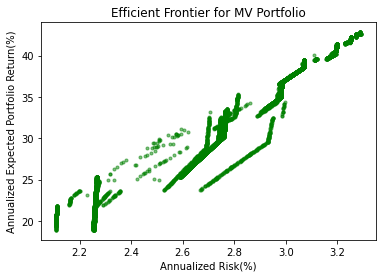

In [113]:
#Graph Efficient Frontier
import matplotlib.pyplot as plt

NoPoints = riskPoint.size

colours = "green"
area = np.pi*3

plt.title('Efficient Frontier for MV Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()

# Naive Portfolio

In [114]:
naive_risks = []
naive_returns = []

for x in np.arange(0, 1, 0.0001):
  weights = [x, 1-x]
  risk = np.matmul((np.matmul(weights,cov)),np.transpose(weights)) * trading_days_in_year
  naive_risks.append(risk)

  #obtain expected portfolio annualized return for the 
  #efficient set portfolios, for trading days = 251
  ret = trading_days_in_year*(np.matmul(weights,r))
  naive_returns.append(ret)

#display efficient set portfolio parameters
# print("Size of the  efficient set:", xOptimalArray.shape )
# print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[naive_risks, naive_returns])

Annualized Risk and Return of the efficient set portfolios: 
 [[ 4.01677562 -4.72959193]
 [ 4.01609527 -4.72483717]
 [ 4.01541519 -4.72008241]
 ...
 [10.91521534 42.80373772]
 [10.91727606 42.80849248]
 [10.91933706 42.81324724]]


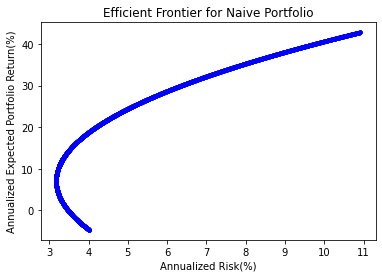

In [115]:
NoPoints = len(naive_risks)

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(naive_risks, naive_returns, s=area, c=colours, alpha =0.5)
plt.show()

# Combined Graph

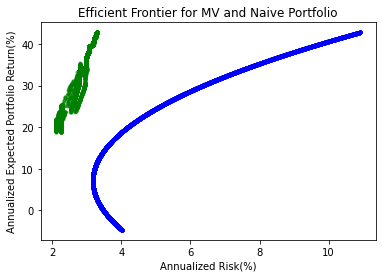

In [116]:
NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3


fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('Efficient Frontier for MV and Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
ax1.scatter(riskPoint, retPoint, s=area, c="green", alpha =0.5)
ax1.scatter(naive_risks, naive_returns, s=area, c="blue", alpha =0.5)
# plt.xlim(riskPoint.min(), riskPoint.max())
plt.show()

In [117]:
cov

,high,low
high,0.043339,0.002438
low,0.002438,0.015940


In [118]:
print(high_risk["Close"].var())
print(high_risk["Close"].var() * trading_days_in_year)
print(high_risk["Close"].pct_change().var())
print(high_risk["Close"].pct_change().var() * trading_days_in_year)

2746.94868824855
692231.0694386346
0.00017197969163255594
0.0433388822914041
